In [10]:
import torch as th
import torch.nn as nn
import geoopt as gt
import torch

from scipy.io import arff
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')
from torch.utils.data import DataLoader

import sys
sys.path.append('..') 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import geoopt as gt

default_dtype = th.float64
th.set_default_dtype(default_dtype)

if th.cuda.is_available():
    cuda_device = th.device('cuda:2')
    th.cuda.set_device(device=cuda_device)
else:
    raise Exception('No CUDA device found.')
    

In [11]:


import geoopt.manifolds.stereographic.math as pmath
from algos import *

class Model(nn.Module):
    
    def __init__(self, feature_num, hidden_size, embed_dim, label_num, **kwargs):
        super().__init__(**kwargs)
        self.ball = gt.PoincareBall(c=1.0)
        points = torch.randn(label_num, embed_dim) 
        points = pmath.expmap0(points.to(cuda_device), k=self.ball.k)
        self.label_emb = gt.ManifoldParameter(points, manifold=self.ball)

    def regularization(self,points):
        return torch.norm(torch.norm(points, p=2, dim=1, keepdim=True) - 0.4, p=2, dim=1, keepdim=True)
    
    def radius_regularization(self,radius):
        return torch.norm(1-radius)
    
    def forward(self, X):
        # implication
        sub_label_id = implication[:,0]
        par_label_id = implication[:,1]
        sub_label_emb = self.label_emb[sub_label_id]
        par_label_emb = self.label_emb[par_label_id]
        inside_loss = F.relu( - self.insideness(sub_label_emb,par_label_emb) )
        dist = self.ball.dist2(sub_label_emb,par_label_emb,keepdim=True)
        inside_reg = torch.norm(dist-2,p=2,dim=1, keepdim=True)
        # exclusion
        left_label_id = exclusion[:,0]
        right_label_id = exclusion[:,1]
        left_label_emb = self.label_emb[left_label_id]
        right_label_emb = self.label_emb[right_label_id]
        disjoint_loss = F.relu(- self.disjointedness(left_label_emb,right_label_emb) )
        label_reg = self.regularization(self.label_emb)
        return 0, inside_loss.mean() + inside_reg.mean(), disjoint_loss.mean(), label_reg.mean(),0
    
    def insideness(self, point_a, point_b,dim=-1):
        point_a_dist = torch.norm(point_a, p=2, dim=dim, keepdim=True)
        point_b_dist = torch.norm(point_b, p=2, dim=dim, keepdim=True)
        radius_a = (1 - point_a_dist**2 )/ (2*point_a_dist )
        radius_b = (1 - point_b_dist**2 )/ (2*point_b_dist )
        center_a = point_a*(1 + radius_a/point_a_dist)
        center_b = point_b*(1 + radius_b/point_b_dist)
        center_dist = torch.norm(center_a-center_b,p=2,dim=dim,keepdim=True)
        insideness =  (radius_b - radius_a) - center_dist
        return insideness
    
    def disjointedness(self, point_a, point_b,dim=-1):
        point_a_dist = torch.norm(point_a, p=2, dim=dim, keepdim=True)
        point_b_dist = torch.norm(point_b, p=2, dim=dim, keepdim=True)
        radius_a = (1 - point_a_dist**2 )/ (2*point_a_dist )
        radius_b = (1 - point_b_dist**2 )/ (2*point_b_dist )
        center_a = point_a*(1 + radius_a/point_a_dist)
        center_b = point_b*(1 + radius_b/point_b_dist)
        center_dist = torch.norm(center_a-center_b,p=2,dim=dim,keepdim=True)
        disjointedness = center_dist - (radius_a + radius_b)
        return disjointedness
    
    def membership(self, point_a, point_b,dim=-1):
        center_a = point_a
        point_b_dist = torch.norm(point_b, p=2, dim=dim, keepdim=True)
        radius_b = (1 - point_b_dist**2 )/ (2*point_b_dist )
        center_b = point_b*(1 + radius_b/point_b_dist)
        center_dist = torch.norm(center_a-center_b,p=2,dim=dim,keepdim=True)
        membership =  radius_b - center_dist
        return membership
        

implication = torch.tensor([[1,0],[2,0],[3,0],[4,1],[4,3],[6,5],[7,3]]).cuda()
exclusion = torch.tensor([[0,5],[1,2],[2,3],[7,1]]).cuda()

labels = ['person','women','girl','parent','mother','plant','tree','father']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:cyan']


from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
# from PoincareLinearClassification.algos import *
# %matplotlib inline
from IPython import display

def plot_hyperplane(points, colors=[],labels=[]):
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.7)
    ax.add_patch(circ)
    plt.scatter(0,0,c='k')

    for point,c,l in zip(points,colors,labels):
        v1 = 1
        v2 = -point[0]/point[1]
        v = torch.tensor([v1,v2])
        plt.scatter(point[0],point[1],c=c)
        plotgeodesic(point, v=v, c=c, l=l, option='pv_line')

        
from sklearn.metrics import accuracy_score,classification_report,average_precision_score
from util.metric import *

lr = 1e-1
hidden_size = 64
embed_dim = 2
label_dim = 8

model = Model(None, hidden_size, embed_dim, label_dim)
model.to(cuda_device)
loss = nn.BCEWithLogitsLoss()
optim = gt.optim.RiemannianAdam(model.parameters(), lr=lr)

def train(epoch, model):
    model.train()
    for e in tqdm(range(1, epoch + 1), desc='train epoch'):
        # training block
        for i in range(10):
            optim.zero_grad()
            _, inside_loss, disjoint_loss, label_reg, _ = model(None)
            train_loss = inside_loss + disjoint_loss + label_reg
            train_loss.backward()
            optim.step()
        
        display.clear_output(wait=True)
        points = model.label_emb.cpu().detach().numpy()
        
        plot_hyperplane(points, colors=colors, labels=labels)
        plt.legend(loc='upper right' )
        plt.show()
        
        
        
        





In [3]:

# epoch = 1000
# train(epoch, model)


NameError: name 'train' is not defined

In [12]:

# torch.save(('model.pt', model)
# 
model = torch.load('model.pt')


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

person 0.6377670146125946
women 0.6200359803532588
girl 0.4647034688926673
parent 0.39549684753108644
mother 0.4677151321518641
plant 0.30718988879734566
tree 0.31202481982888286
father 0.19557031749304313


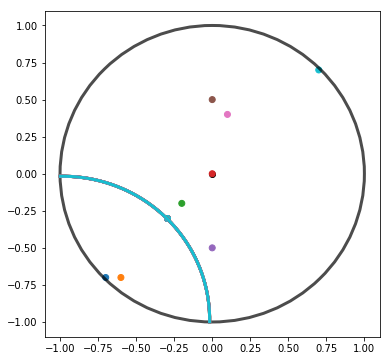

In [6]:

labels = ['person','women','girl','parent','mother','plant','tree','father']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:cyan']

label = torch.tensor([[-0.5,-0.5]])
points = torch.tensor([[-0.7,-0.7],[-0.6,-0.7],[-0.2,-0.2],[0,0],[0,-0.5],[0,0.5],[0.1,0.4],[0.7,0.7]])
label_emb = torch.tensor([[-0.3,-0.3],[-0.3,-0.3],[-0.3,-0.3],[-0.3,-0.3],[-0.3,-0.3],[-0.3,-0.3],[-0.3,-0.3],[-0.3,-0.3]])
    
plot_hyperplane(label_emb, colors, labels)
plt.scatter(points[:,0],points[:,1], c=colors)

# plt.scatter(label_emb[:,0],label_emb[:,1])

for i in range(8):
    print(labels[i], F.sigmoid(model.membership(points,label_emb))[:,0][i].item() )
    

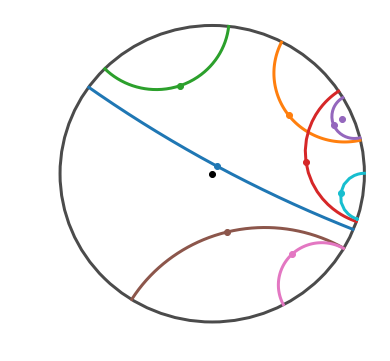

In [74]:


labels = ['person','women','girl','parent','mother','plant','tree','father']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:cyan']

point = torch.tensor([[0.85,0.37]])
points = point.repeat(8,1)


label_emb = model.label_emb[0:8,:].cpu().detach()
# label_emb[0] = torch.tensor([[0.0838,  0.0107]])
# label_emb[3] = torch.tensor([[0.6010, -0.1018]])
# label_emb[4] = torch.tensor([[0.7802, -0.3701]])
# label_emb[5] = torch.tensor([[-0.361, -0.1325]])
# label_emb[6] = torch.tensor([[-0.5361, -0.4325]])
# label_emb[7] = torch.tensor([[0.8178, -0.0228]])
plot_hyperplane(label_emb, colors, labels)
# plt.legend(loc='left upper', fontsize=17)

plt.scatter(point[:,0],point[:,1],color='tab:purple')
plt.axis('off')
plt.savefig('labelembedding.pdf', bbox_inches='tight', pad_inches=0, dpi=1200)



In [15]:
label_emb

tensor([[ 0.1238,  0.0127],
        [ 0.5075, -0.4219],
        [ 0.4230,  0.4978],
        [ 0.6610, -0.1618],
        [ 0.7802, -0.4051],
        [-0.1361, -0.6325],
        [ 0.0470, -0.8665],
        [ 0.8778, -0.0098]])

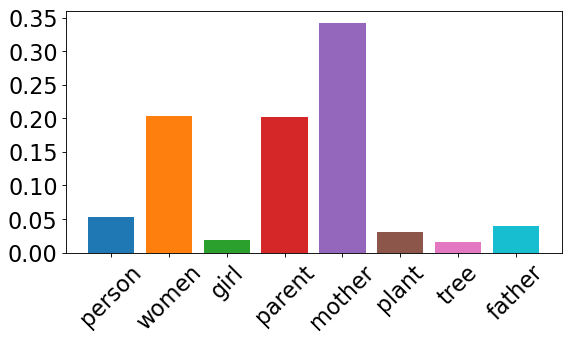

In [75]:

dist_probability = F.sigmoid(-model.ball.dist2plane(points.cuda(),label_emb.cuda(),-label_emb.cuda()) )

plt.figure(figsize=(8, 4), dpi=80)

probability = dist_probability.cpu().detach()

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.bar(labels, probability, color =colors)
plt.savefig('dist_probability.pdf', bbox_inches='tight', pad_inches=0, dpi=1200)




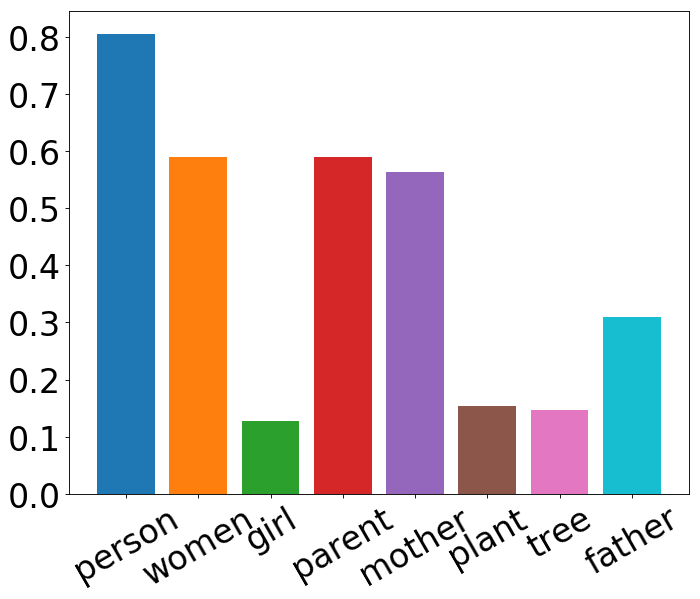

In [83]:

plt.figure(figsize=(10, 8), dpi=80)

probability_2 = F.sigmoid(model.insideness(points,label_emb) - model.disjointedness(points,label_emb))[:,0]


plt.xticks(fontsize=30, rotation=30)
plt.yticks(fontsize=30)
plt.bar(labels, probability_2, color =colors)
# plt.axhline(y=0.5, color='black', linestyle='--',label='t')
plt.savefig('mother.pdf', bbox_inches='tight', pad_inches=0, dpi=1200)



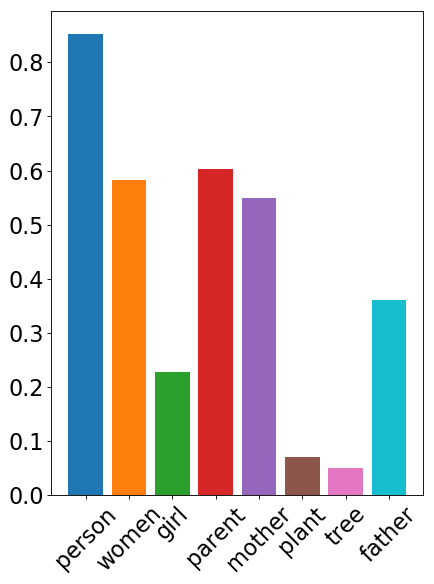

In [63]:

plt.figure(figsize=(6, 8), dpi=80)

probability = F.sigmoid(model.insideness(points,label_emb) - model.disjointedness(points,label_emb))[:,0]
plt.bar(labels, probability, color =colors)
# plt.legend(loc='best', fontsize=)
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
plt.savefig('mother.pdf', bbox_inches='tight', pad_inches=0, dpi=1200)

